# **ROI Extraction:**

In [1]:
!pip install --upgrade pip
!pip install opencv-contrib-python

# PATH configuration

In [1]:
# path to directory with original images
inputDir = r'D:\Archive\Uni\Subjects\DL_Network_v1\samples'
# image name
imgName = 'WSI.svs'
# path to the directory where the extracted patches will be saved
outputDir = r'D:\Archive\Uni\Subjects\DL_Network_v1\output'

# path to classification model (optional)
modelPath = r'D:\Archive\Uni\Subjects\DL_Network_v1\best_model.pth'

# Hyperparameters

In [2]:
# Gaussian Kernel Size for GaussianBlur() function
kSize = (25,25)
# threshold value which is used to classify the pixel values (0 -> 255)
threshold_val = 240
# number of points in one curve section
def_step = 1500
# bounding box width in pixels
bb_width = 1600
# bounding box height in pixels
bb_height = 2300
# holds the percentage by which image has to be scaled
scale_percent = 0.15
# preferred magnification (1x -> Nx)
target_mgn = 4

# (a) Threshold operation

In [3]:
import cv2
import numpy as np
import os
import openslide

# generate path to input image
path = os.path.join(inputDir, imgName)
# original input slide
slide = openslide.OpenSlide(path)

# get level with lowest magnification
min_mgn_lvl = slide.level_count - 1
# get slide max magnification
max_mgn = slide.level_downsamples[min_mgn_lvl]

# get all possible magnifications
mgn_list = []
for mng in slide.level_downsamples:
    mgn_list.append(max_mgn / mng)

# reverse list of magnifications
mgn_list = mgn_list[::-1]

# get optimal level for target magnification
# get precise magnification for optimal level
max_idx = len(mgn_list) - 1
optimal_mgn_lvl = max_idx
for idx, val in enumerate(mgn_list):
    if target_mgn >= val:
        optimal_mgn_lvl = max_idx - idx
        if idx == max_idx:
            target_mgn = mgn_list[max_idx - optimal_mgn_lvl]
    else:
        target_mgn = mgn_list[max_idx - optimal_mgn_lvl]
        break

# get size of the slide with lowest magnification
min_mgn_size = slide.level_dimensions[min_mgn_lvl]
# get full slide with lowest magnification
min_mgn_slide = slide.read_region((0, 0), min_mgn_lvl, min_mgn_size)

# convert received image from RGBA to BGR
img = min_mgn_slide.convert('RGB')
img = np.array(img)
img = img[:, :, ::-1].copy()

# flip image vertically
img = cv2.flip(img, 0)

# downscaled image
lowRes = cv2.resize(img, (0,0), fx=scale_percent, fy=scale_percent, interpolation = cv2.INTER_AREA)
cv2.imshow("Downscaled image", lowRes)
cv2.waitKey(0)

# set image to gray color
gray = cv2.cvtColor(lowRes, cv2.COLOR_BGR2GRAY)
cv2.imshow("Gray", gray)
cv2.waitKey(0)

# blur the gray image
img_blur = cv2.GaussianBlur(gray, kSize, cv2.BORDER_DEFAULT)
cv2.imshow("Blur", img_blur)
cv2.waitKey(0)

# applying threshold
ret, thresh = cv2.threshold(img_blur, threshold_val, 255, cv2.THRESH_BINARY)
cv2.imshow("Threshold", thresh)
cv2.waitKey(0)

# finding contours
contours, hierarchies = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# draw all contours
blank = np.zeros(lowRes.shape, dtype="uint8")
cv2.drawContours(blank, contours, -1, (0,0,255), 1)
cv2.imshow("Contours Drawn", blank)
cv2.waitKey(0)

# draw area of the image with no ROI
imgFullContour = lowRes.copy()
cv2.drawContours(imgFullContour, contours, len(contours) - 1, (255,0,0), 1)
cv2.imshow("Main area", imgFullContour)
cv2.waitKey(0)

# removing of picture borders
target_contour = contours[len(contours) - 1]
height = lowRes.shape[0]
width = lowRes.shape[1]

main_edge = []

for point in target_contour:
    if point[0][0] == 0 or point[0][0] == width - 1:
        continue
    elif point[0][1] == 0 or point[0][1] == height - 1:
        continue
    else:
        main_edge.append(point)

# draw main edge
imgMainEdge = lowRes.copy()
cv2.drawContours(imgMainEdge, main_edge, -1, (255,0,0), 2)
cv2.imshow("Main edge", imgMainEdge)
cv2.waitKey(0)

cv2.destroyAllWindows()

# (b) Draw tangents and rectangular boxes on graph

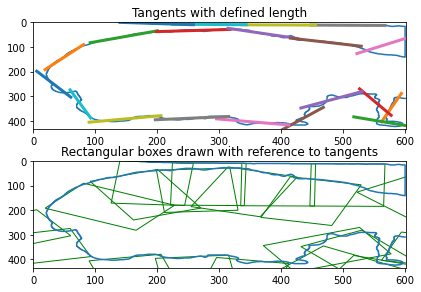

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# m is the slope of line, and the
# required Point lies distance l
# away from the source Point
def findLinePoints(sourcePoint, l, m):    
    a = [0, 0]
    b = [0, 0]
 
    # slope is 0
    if m == 0:
        a[0] = sourcePoint[0] - l/2
        a[1] = sourcePoint[1]
 
        b[0] = sourcePoint[0] + l/2
        b[1] = sourcePoint[1]
        
    # if slope is infinite
    elif math.isinf(m):
        a[0] = sourcePoint[0]
        a[1] = sourcePoint[1] - l/2
 
        b[0] = sourcePoint[0]
        b[1] = sourcePoint[1] + l/2
    else:
        dx = (l/2) / math.sqrt(1 + m * m)
        dy = m * dx
        a[0] = sourcePoint[0] - dx
        a[1] = sourcePoint[1] - dy
        b[0] = sourcePoint[0] + dx
        b[1] = sourcePoint[1] + dy
 
    return a,b
    
# get arrays of coordinates
x = np.array([])
y = np.array([])
for point in main_edge:
    x = np.append(x, point[0][0])
    y = np.append(y, point[0][1])
    
# subplots configuration
fig, (ax1, ax2) = plt.subplots(2)
fig.tight_layout()

ax1.set_title('Tangents with defined length')
ax1.set_xlim([0, lowRes.shape[1]]) 
ax1.set_ylim([0, lowRes.shape[0]])
ax1.invert_yaxis()
ax1.plot(x, y)

ax2.set_title('Rectangular boxes drawn with reference to tangents')
ax2.set_xlim([0, lowRes.shape[1]])
ax2.set_ylim([0, lowRes.shape[0]])
ax2.invert_yaxis()
ax2.plot(x, y)

# set tangent length related to scale percentage and magnification
tangentLen = int(bb_width * scale_percent / target_mgn)
# set rectangle height related to scale percentageand magnification
rectHeight = int(bb_height * scale_percent / target_mgn)
# set step related to scale percentage and magnification
step = int(def_step * scale_percent / target_mgn)

# set curve start point
sp = 0

while sp < len(main_edge):
    # get curve section
    curvePiece_OX = x[sp : sp + step]
    curvePiece_OY = y[sp : sp + step]
    
    # find tangent with undefined length for curve section
    m, b = np.polyfit(curvePiece_OX, curvePiece_OY, 1)
    tangent = [curvePiece_OX, m*curvePiece_OX + b]
    
    # find optimal point for building tangent with defined length
    X_mean = np.mean(tangent[0], dtype=np.float64)
    closestToMean = min(tangent[0], key=lambda x:abs(x - X_mean))
    closestToMeanInd = np.where(tangent[0] == closestToMean)[0]
    temp = closestToMeanInd[0]
    sourcePoint = [tangent[0][temp], tangent[1][temp]]
    
    # get extreme points of a tangent with defined length
    a, b = findLinePoints(sourcePoint, tangentLen, m)
    X_axis = [a[0], b[0]]
    Y_axis = [a[1], b[1]]
    
    # plot tangent with defined length
    ax1.plot(X_axis, Y_axis, linewidth="3")
    
    # get a tangent angle
    tangentAngle = np.rad2deg(np.arctan2(Y_axis[-1] - Y_axis[0], X_axis[-1] - X_axis[0]))
    # draw rectangular box with reference to tangents
    ax2.add_patch(Rectangle(a, tangentLen, rectHeight, 
                                           angle=tangentAngle,
                                           edgecolor='green',
                                           facecolor='none', 
                                           lw=1))
    
    # update curve section
    sp = sp + step

# (c) Draw ROI boxes / get patches

In [5]:
import numpy as np
import math
from scipy.spatial import distance as dist
import os
import glob

def get_patch(a, b, imgROI):
    # Get the direction vector for given points
    v = [b[0] - a[0], b[1] - a[1]]
    # Normalize the vector
    mag = math.sqrt(v[0]*v[0] + v[1]*v[1])
    v = [v[0]/mag, v[1]/mag]
    # Rotate the vector 90 degrees by swapping x and y, and inverting one of them
    v = [0 - v[1], v[0]]
    # Create a new line (side of rectangle) at B pointing in the direction of v
    c = [b[0] + v[0] * rectHeight, b[1] + v[1] * rectHeight]
    # Create a new line (side of rectangle) at A pointing in the direction of v
    d = [a[0] + v[0] * rectHeight, a[1] + v[1] * rectHeight] 
    
    # form box from points and order them clockwise
    box = np.array([a, b, c, d])
    # convert box points to int
    box_int = np.int0(box)
    
    # draw bounding box over original image
    cv2.drawContours(imgROI, [box_int], 0, (0, 255, 0), 2)
    
    # find bounding box coordinates for high resolution image
    box = box / scale_percent
    # adjust bounding box coordinates for slide with target magnification
    box = box * target_mgn
    
    # determine top left and bottom right pixels in the preferred level reference frame 
    topLeft_pts = np.copy(box[0])
    bottomRight_pts = np.copy(box[0])
    for i in range(1, 4):
        if box[i][0] < topLeft_pts[0]:
            topLeft_pts[0] = box[i][0]
        if box[i][1] < topLeft_pts[1]:
            topLeft_pts[1] = box[i][1]
            
        if box[i][0] > bottomRight_pts[0]:
            bottomRight_pts[0] = box[i][0]
        if box[i][1] > bottomRight_pts[1]:
            bottomRight_pts[1] = box[i][1]
            
    # convert coordinates to int
    topLeft_pts = np.int0(topLeft_pts)
    bottomRight_pts = np.int0(bottomRight_pts)
        
    # get fragment size
    fragment_size = (bottomRight_pts[0] - topLeft_pts[0], bottomRight_pts[1] - topLeft_pts[1])
    
    # determine top left pixels in the level 0 reference frame (used for slide fragment extraction)
    target_slide_size = slide.level_dimensions[optimal_mgn_lvl]
    topleft_pts_lvl_0 = np.int0([topLeft_pts[0], target_slide_size[1] - bottomRight_pts[1]])
    if optimal_mgn_lvl > 0:
        mgn_diff = max_mgn / target_mgn
        topleft_pts_lvl_0 = np.int0(topleft_pts_lvl_0 * mgn_diff)
        
    # extract fragment which contains bounding box
    slide_fragment = slide.read_region(topleft_pts_lvl_0, optimal_mgn_lvl, fragment_size)
    
    # convert extracted fragment from RGBA to BGR
    slide_fragment = slide_fragment.convert('RGB')
    slide_fragment = np.array(slide_fragment)
    slide_fragment = slide_fragment[:, :, ::-1].copy()
    
    # flip extracted fragment
    slide_fragment = cv2.flip(slide_fragment, 0)
        
    # find local bounding box coordinates inside extracted fragment
    src_pts = np.int0(box)
    for pt in src_pts:
        pt[0] = pt[0] - topLeft_pts[0]
        pt[1] = pt[1] - topLeft_pts[1]
    
    # bounding box coordinates connverted to float
    src_pts = src_pts.astype("float32")
    
    # coordinates of the straightened bounding box (rectangle)
    dst_pts = np.array([[0, 0],
                        [bb_width-1, 0],
                        [bb_width-1, bb_height-1],
                        [0, bb_height-1]], dtype="float32")
                
    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(slide_fragment, M, (bb_width, bb_height))
    
    # Change the current directory to specified directory
    os.chdir(subDir)
    
    # get number of previously saved patches
    patchCount = len(glob.glob1(subDir,'*.jpg'))
    
    # save the patch as new image
    cv2.imwrite("patch_" + str(patchCount) + ".jpg", warped)

# create directory dedicated to current image
topDir = os.path.join(outputDir, imgName[0:-4])
if not os.path.exists(topDir):
    os.makedirs(topDir)

# copy original image to created directory
os.chdir(topDir)
cv2.imwrite("Original.jpg", img)

# create sub directory for image patches
# remove all patches from the directory if it already exists
subDir = os.path.join(topDir, 'Patches')
if not os.path.exists(subDir):
    os.makedirs(subDir)
else:
    pathToPatches = os.path.join(subDir, '*.jpg')
    patches = glob.glob(pathToPatches)
    for patch in patches:
        os.remove(patch)

# copy of original image for drawing bounding boxes
imgROI = lowRes.copy()
    
# get arrays of coordinates
x = np.array([])
y = np.array([])
for point in main_edge:
    x = np.append(x, point[0][0])
    y = np.append(y, point[0][1])

# set tangent length related to scale percentage and magnification
tangentLen = int(bb_width * scale_percent  / target_mgn)
# set rectangle height related to scale percentage and magnification
rectHeight = int(bb_height * scale_percent  / target_mgn)
# set step related to scale percentage and magnification
step = int(def_step * scale_percent  / target_mgn)
    
# set curve start point
sp = 0

while sp < len(main_edge):    
    # get curve section
    curvePiece_OX = x[sp : sp + step]
    curvePiece_OY = y[sp : sp + step]
    
    # find tangent with undefined length for curve section
    m, b = np.polyfit(curvePiece_OX, curvePiece_OY, 1)
    tangent = [curvePiece_OX, m*curvePiece_OX + b]
        
    # find optimal point for building tangent with defined length
    X_mean = np.mean(tangent[0], dtype=np.float64)
    closestToMean = min(tangent[0], key=lambda x:abs(x - X_mean))
    closestToMeanInd = np.where(tangent[0] == closestToMean)[0]
    temp = closestToMeanInd[0]
    sourcePoint = [tangent[0][temp], tangent[1][temp]]
    
    # get extreme points of a tangent with defined length
    a, b = findLinePoints(sourcePoint, tangentLen, m)
    
    # extract patches from original image
    get_patch(a, b, imgROI)
    
    # update curve section
    sp = sp + step

# save original image with drawn bounding boxes
os.chdir(topDir)
cv2.imwrite("Bounding boxes visualization.jpg", imgROI)

# create txt file with saved hyperparameters values
f = open("Hyperparameters.txt","w+")
f.write(f"""Gaussian Kernel Size for GaussianBlur() function: {kSize}
Threshold value: {threshold_val}
Number of points in one curve section: {def_step}
Bounding box width: {bb_width}
Bounding box height: {bb_height}
Percentage by which image was scaled: {scale_percent}
Slide magnification: {target_mgn}""")
f.close()

# Displaying the image
cv2.imshow("Original image with ROI", imgROI)
cv2.waitKey(0)

cv2.destroyAllWindows()

# (d) Patch classification (optional)

In [6]:
import torch
from torchvision.models import DenseNet

# load network
gpuid = 0
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load(modelPath, map_location=lambda storage, loc: storage) #load checkpoint to CPU
model = DenseNet(growth_rate=checkpoint["growth_rate"], block_config=checkpoint["block_config"],
                 num_init_features=checkpoint["num_init_features"], bn_size=checkpoint["bn_size"],
                 drop_rate=checkpoint["drop_rate"], num_classes=checkpoint["num_classes"]).to(device)

model.load_state_dict(checkpoint["model_dict"])
model.eval()

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	415554


In [7]:
# Generate input patches list

# check output folder on emptiness
pathToPatches = os.path.join(subDir, '*.jpg')
input_patches = glob.glob(pathToPatches)
if (len(input_patches) == 0):
    raise NameError('Output folder has no patches to classify')
else:
    print(f'Patches found: {len(input_patches)}')

# generate path to patches classified as 'negative'
patch_neg_dir = os.path.join(subDir, "negative")
# generate path to patches classified as 'positive'
patch_pos_dir = os.path.join(subDir, "positive")

# create folder for storing patches classified as 'negative'
# or clear this folder if it's not empty
if not os.path.exists(patch_neg_dir):
    os.makedirs(patch_neg_dir)
else:
    pathToPatches = os.path.join(patch_neg_dir, '*.jpg')
    patches = glob.glob(pathToPatches)
    for patch in patches:
        os.remove(patch)
        
# create folder for storing patches classified as 'positive'
# or clear this folder if it's not empty
if not os.path.exists(patch_pos_dir):
    os.makedirs(patch_pos_dir)
else:
    pathToPatches = os.path.join(patch_pos_dir, '*.jpg')
    patches = glob.glob(pathToPatches)
    for patch in patches:
        os.remove(patch)

Patches found: 7


In [17]:
from patchify import patchify

batch_size = 1
patch_size = 224
stride_size = patch_size//2

# helper function to split data into batches
def divide_batch(l, n): 
    for i in range(0, l.shape[0], n):  
        yield l[i:i + n, :, :, :]

# work on files
for pname in input_patches:

    pname = pname.strip()
    print(f"working on patch: \t {pname}")

    io = cv2.cvtColor(cv2.imread(pname),cv2.COLOR_BGR2RGB)
    #io = cv2.resize(io, (0, 0), fx=1, fy=1)
    
    #add half the stride as padding around the image, so that we can crop it away later
    io = np.pad(io, [(stride_size//2, stride_size//2), (stride_size//2, stride_size//2), (0, 0)], mode="reflect")
    
    io_shape_wpad = np.array(io.shape)
    
    #pad to match an exact multiple of net patch size, otherwise last row/column are lost
    npad0 = int(np.ceil(io_shape_wpad[0] / patch_size) * patch_size - io_shape_wpad[0])
    npad1 = int(np.ceil(io_shape_wpad[1] / patch_size) * patch_size - io_shape_wpad[1])
    io = np.pad(io, [(0, npad0), (0, npad1), (0, 0)], mode="constant")
    
    arr_out=patchify(io, (patch_size, patch_size, 3), step=stride_size)
    arr_out = arr_out.reshape(-1,patch_size,patch_size,3)
    
    #in case we have a large network, lets cut the list of tiles into batches
    output = np.zeros((0,checkpoint["num_classes"]))     
    for batch_arr in divide_batch(arr_out,batch_size):
        
        arr_out_gpu = torch.from_numpy(batch_arr.transpose(0, 3, 1, 2) / 255).type('torch.FloatTensor').to(device)

        # get results
        output_batch = model(arr_out_gpu)

        # pull from GPU and append to rest of output 
        output_batch = output_batch.detach().cpu().numpy()
        output = np.append(output,output_batch,axis=0)

    tileclass = np.argmax(output, axis=1)
    
    predc,predccounts=np.unique(tileclass, return_counts=True)    
    for c,cc in zip(predc,predccounts):
        print(f"class/count: \t{c}\t{cc}")
    
    imgclass = predc[np.argmax(predccounts)]
    print(f"predicted class:\t{imgclass}")
    
    # change path directory according to class
    pname_short = pname.rpartition(os.sep)[-1]
    
    if imgclass == 0:
        os.replace(pname, os.path.join(patch_neg_dir, pname_short))
    elif imgclass == 1:
        os.replace(pname, os.path.join(patch_pos_dir, pname_short))

working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\7651-52-20-0061\Patches\patch_0.jpg
class/count: 	0	135
predicted class:	0
working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\7651-52-20-0061\Patches\patch_1.jpg
class/count: 	0	125
class/count: 	1	10
predicted class:	0
working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\7651-52-20-0061\Patches\patch_2.jpg
class/count: 	0	130
class/count: 	1	5
predicted class:	0
working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\7651-52-20-0061\Patches\patch_3.jpg
class/count: 	0	17
class/count: 	1	118
predicted class:	1
working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\7651-52-20-0061\Patches\patch_4.jpg
class/count: 	0	16
class/count: 	1	119
predicted class:	1
working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\7651-52-20-0061\Patches\patch_5.jpg
class/count: 	0	59
class/count: 	1	76
predicted class:	1
working on patch: 	 E:\Archive\Uni\Subjects\DL_Network_v1\output\76